# Cell Tracking Deep Learning Model

Nanyan "Rosalie" Zhu & Chen "Raphael" Liu

Background: ......


## 1. System Setup

### 1.1 Import packages

In [1]:
import sys
import os
from shutil import copyfile
from torch.backends import cudnn
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import rank
from scipy import ndimage
import scipy.ndimage.morphology as ndi_morph
import skimage.morphology as skimage_morph
import warnings

### 1.2 Define Paths

In [2]:
dataset_path = '/media/sail/SSD1T/Tal_cell_tracking/Cell_movie/'
deep_learning_model_path = './deep_learning_model/'

### 1.3 Add the deep_learning_model folder to system path.
We did this in order to import files from the deep_learning_model folder and to make sure files inside can import from each other.

In [3]:
sys.path.append(deep_learning_model_path)

### 1.4 Import functions and objects from files.

In [5]:
from solver import Solver
from data_loader import get_loader
from evaluation import get_MSE

$$\space$$

## 2. Inspect the input (RGB images) and target (Gound Truth Segmentation) to the deep learning network.

### 2.1 Grab all the file directories in each category.

In [13]:
GT_files = []
img_files = []
for path, folder, files in os.walk(dataset_path):
    if folder == []:
        if path.split('/')[-1] == 'RRGroundTruthMask':
            for name in list(np.sort(files)):
                GT_files.append(os.path.join(path, name))
        elif path.split('/')[-1] == 'Combined3Channels':
            for name in list(np.sort(files)):
                img_files.append(os.path.join(path, name))
GT_train = list(np.sort(glob('/media/sail/SSD1T/Tal_cell_tracking/Nifti/annotation/*.png')))[1:]

In [14]:
img_train = []
train_image_name = [path.split('/')[-1].replace('annotation', 'Combined') for path in GT_train]
name_list = [path.split('/')[-1] for path in img_files]
for name in train_image_name:
    img_train.append(img_files[name_list.index(name)])
GT_val = GT_train
GT_test = []

img_val = img_train
img_test = []
         
# test set
for file in GT_files:
    for folder in ['A1', 'D4']:
        if folder in file.split('/')[-3] and int(file.split('/')[-1][-6:-4]) < 31:
            GT_test.append(file)
            
for file in img_files:
     for folder in ['A1', 'D4']:
        if folder in file.split('/')[-3] and int(file.split('/')[-1][-6:-4]) < 31:
            img_test.append(file)

In [15]:
img_train, GT_train

(['/media/sail/SSD1T/Tal_cell_tracking/Cell_movie/A2/Combined3Channels/A2_Combined_T02.png',
  '/media/sail/SSD1T/Tal_cell_tracking/Cell_movie/D5/Combined3Channels/D5_Combined_T02.png',
  '/media/sail/SSD1T/Tal_cell_tracking/Cell_movie/D5/Combined3Channels/D5_Combined_T45.png'],
 ['/media/sail/SSD1T/Tal_cell_tracking/Nifti/annotation/A2_annotation_T02.png',
  '/media/sail/SSD1T/Tal_cell_tracking/Nifti/annotation/D5_annotation_T02.png',
  '/media/sail/SSD1T/Tal_cell_tracking/Nifti/annotation/D5_annotation_T45.png'])

In [16]:
len(GT_train), len(img_train), len(GT_val), len(img_val), len(GT_test), len(img_test)

(3, 3, 3, 3, 60, 60)

$$\space$$

## 3. Build the Deep Learning Network.

### 3.1 Define the class "config" (configuration) that passes parameters to the loader and solver.

### 3.5 Train the model.

In [17]:
warnings.filterwarnings(action = 'once')

## Unet Layer and kernal number trials

In [19]:
UnetLayers = int(5) # [int(5), int(4), int(3)]:    
firstlayerkernal = int(32) # [int(64), int(48), int(32), int(16)]:
class config():   
    # model hyper-parameters
    t = int(3) # t for Recurrent step of R2U_Net or R2AttU_Net'
    img_ch = int(3)
    GT_ch = int(1)
    output_ch = int(1)
    num_epochs = int(30)
    num_workers = int(1)
    patch_size = [800, 800]
    patch_num = 24 # the actual patch will be 96 / down_factor ** 2
    row_num = 4
    down_factor = 1
    mode = 'train'
    debug = False

    ############################### Adjust These ###################################
    model_type = 'ResAttU_Net' # 'U_Net/R2U_Net/AttU_Net/R2AttU_Net/ResAttU_Net'
    optimizer_choice = 'SGD'
    annotation_num = len(img_train)
    lr = float(0.05)  # initial learning rate
    loss_function = 'BCE' # BCE/SmoothL1/
    batch_size = int(1)
    UnetLayer = UnetLayers
    withTF = False
    edge_enhance = 'Double' # 'True/Double'
    first_layer_numKernel = firstlayerkernal



    early_stop = False # shall we enable early stop?
    ################################################################################

    if optimizer_choice == 'Adam':
        beta1 = float(0.5) # momentum1 in Adam
        beta2 = float(0.999) # momentum2 in Adam
    elif optimizer_choice == 'SGD':
        momentum = float(0.9)
    else:
        print('No such optimizer available')

    img_train = img_train
    img_val = img_val
    img_test = img_test

    GT_train = GT_train
    GT_val = GT_val
    GT_test = GT_test
    
    result_path = './result/num_annotation_%d/' % annotation_num
    model_weights_path = result_path + 'model_weights/'
    predictions_path = result_path + 'predictions/'
    loss_histories_path = result_path + 'loss_histories/'
    test_result_comparison_path = result_path + 'test_result_comparison/'
    

    current_model_saving_path = model_weights_path + \
    'edge_enhance_%s/%s/%s/learning_rate_%.4f/loss_function_%s/batch_size_%d/unet_layer_%d/first_layer_numKernel_%d/' % (edge_enhance, model_type, optimizer_choice, lr, loss_function, batch_size, UnetLayer, first_layer_numKernel)
    current_prediction_path = predictions_path + \
    'edge_enhance_%s/%s/%s/learning_rate_%.4f/loss_function_%s/batch_size_%d/unet_layer_%d/first_layer_numKernel_%d/' % (edge_enhance, model_type, optimizer_choice, lr, loss_function, batch_size, UnetLayer, first_layer_numKernel)
    current_loss_history_path = loss_histories_path + \
    'edge_enhance_%s/%s/%s/learning_rate_%.4f/loss_function_%s/batch_size_%d/unet_layer_%d/first_layer_numKernel_%d/' % (edge_enhance, model_type, optimizer_choice, lr, loss_function, batch_size, UnetLayer, first_layer_numKernel)
    

    cuda_idx = int(1)


cudnn.benchmark = True
if config.model_type not in ['U_Net','R2U_Net','AttU_Net','R2AttU_Net', 'ResAttU_Net']:
    print('ERROR!! model_type should be selected in U_Net/R2U_Net/AttU_Net/R2AttU_Net/ResAttU_Net')
    print('Your input for model_type was %s'%model_type)

for this_directory in [config.current_model_saving_path, config.current_loss_history_path, config.test_result_comparison_path]:
    if not os.path.exists(this_directory):
        os.makedirs(this_directory)

train_loader = get_loader(config, mode = 'train')

validation_loader = get_loader(config, mode = 'validation')

test_loader = get_loader(config, mode = 'test', shuffle = False)

warnings.filterwarnings(action = 'once')
solver = Solver(config, train_loader, validation_loader, test_loader)
train_loss_history, validation_loss_history = solver.train()

np.save(config.current_loss_history_path + 'train_loss_history.npy', train_loss_history)
np.save(config.current_loss_history_path + 'validation_loss_history.npy', validation_loss_history)

image count in train path :3
GT count in train path :3
image count in validation path :3
GT count in validation path :3
image count in test path :60
GT count in test path :60
The U-Net path is ./result/num_annotation_3/model_weights/edge_enhance_Double/ResAttU_Net/SGD/learning_rate_0.0500/loss_function_BCE/batch_size_1/unet_layer_5/first_layer_numKernel_32/ResAttU_Net-SGD-0.0500-30-1-1-best.pkl
Start training. The initial learning rate is: 0.05


/home/raphael/anaconda3/envs/Cyto/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


[Training] Epoch [1/30], Batch: 0, Batch size: 1, Average BCE Error: 0.6582600474357605
[Training] Epoch [1/30], Train Loss: 0.162970, Run Time: 0.0243 [h]
Current learning rate: 0.05
[Validation] Epoch [1/30] Validation Loss: 0.178698, Run Time: 0.0012 [h]
Best ResAttU_Net model score : 0.821302
[Training] Epoch [2/30], Batch: 0, Batch size: 1, Average BCE Error: 0.09232208877801895
[Training] Epoch [2/30], Train Loss: 0.088772, Run Time: 0.0248 [h]
Current learning rate: 0.05
[Validation] Epoch [2/30] Validation Loss: 0.167846, Run Time: 0.0012 [h]
Best ResAttU_Net model score : 0.832154
[Training] Epoch [3/30], Batch: 0, Batch size: 1, Average BCE Error: 0.08356746286153793
[Training] Epoch [3/30], Train Loss: 0.085273, Run Time: 0.0246 [h]
Current learning rate: 0.05
[Validation] Epoch [3/30] Validation Loss: 0.154870, Run Time: 0.0011 [h]
Best ResAttU_Net model score : 0.845130
[Training] Epoch [4/30], Batch: 0, Batch size: 1, Average BCE Error: 0.14730054140090942
[Training] Epoc

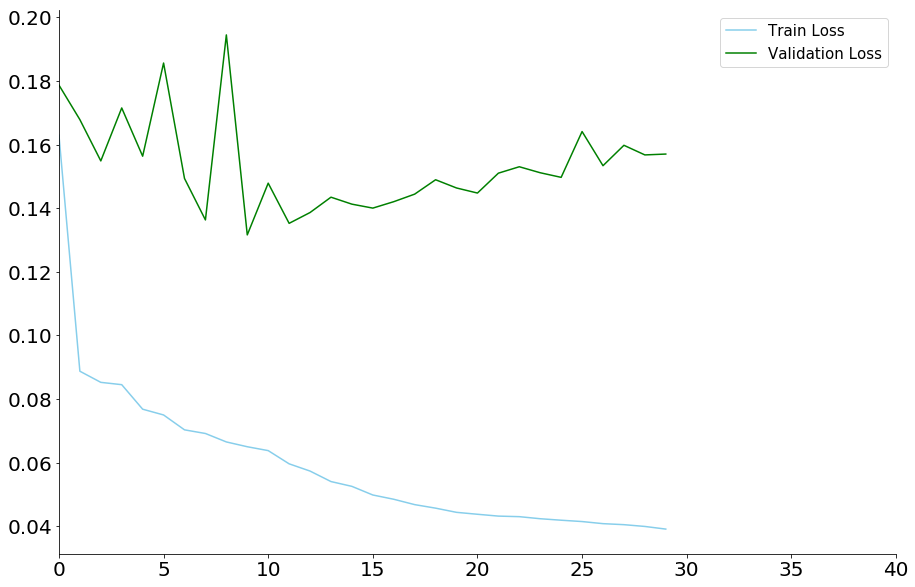

In [20]:
train_loss_history = np.load(config.current_loss_history_path + 'train_loss_history.npy')
validation_loss_history = np.load(config.current_loss_history_path + 'validation_loss_history.npy')
fig, ax = plt.subplots(1,1, figsize= (15, 10))
ax.plot(train_loss_history, color = 'skyblue')
ax.plot(validation_loss_history, color = 'g')
ax.set_xlim([0, 40])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(('Train Loss', 'Validation Loss'), fontsize = 15)